In [30]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


In [33]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [34]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [35]:
CSV_FILE ='/content/Human-Segmentation-Dataset-master/train.csv'
DARA_DIR ='/content/'
DEVICE='cuda'
EPOCHS = 25
LR = 0.003
BATCH_SIZE = 16
IMG_SIZE = 320
ENCODER ='timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [36]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [37]:
row = df.iloc[5]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

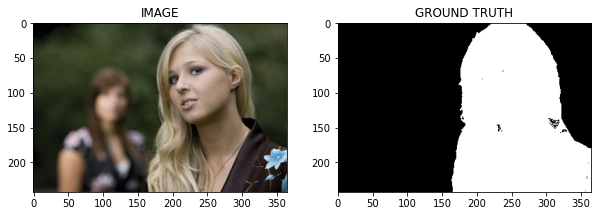

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [39]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state=42)



In [40]:
import albumentations as A

In [41]:
def get_train_augs():
  return A.Compose([A.Resize(IMG_SIZE, IMG_SIZE),A.HorizontalFlip(p = 0.5),A.VerticalFlip(p=0.5)])

def get_valid_augs():
  return A.Compose([A.Resize(IMG_SIZE, IMG_SIZE)])

In [42]:
from torch.utils.data import Dataset

In [43]:
class SegmentationDataset(Dataset):

  def __init__(self,df,augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    iamge = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image = image, mask=mask)
      image = data['image']
      mask = data['mask']
#(h,w,c)->(c,h,w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)
    return image, mask

In [44]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [45]:
print(f"Size of Trainset :{len(trainset)}")
print(f"Size of Validset :{len(validset)}")


Size of Trainset :232
Size of Validset :58


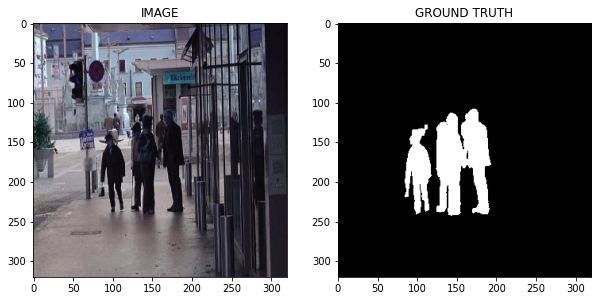

In [46]:
idx = 45
image, mask =trainset[idx]
helper.show_image(image,mask)

In [47]:
from torch.utils.data import DataLoader

In [48]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [49]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [50]:
for image, mask in trainloader:
  break

print(f"one batch image shape : {image.shape}")  
print(f"one batch image shape : {mask.shape}")

one batch image shape : torch.Size([16, 3, 320, 320])
one batch image shape : torch.Size([16, 1, 320, 320])


In [51]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


In [52]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(encoder_name = ENCODER, encoder_weights = WEIGHTS,in_channels = 3, classes = 1, activation =None)

  def forward(self, images, masks = None):

    logits=self.arc(images)

    if masks !=None:
      loss1 = DiceLoss(mode ='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2

    return logits

In [53]:
model = SegmentationModel()
model.to(DEVICE);

In [54]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)


In [55]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      
      logits, loss = model(images, masks)
      

      total_loss += loss.item()

    return total_loss / len(data_loader)


In [56]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [57]:
from segmentation_models_pytorch import losses
best_valid_loss = np.Inf
train_los=[]
val_los=[]
for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)
  train_los.append(train_loss)
  val_los.append(valid_loss)
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
    best_valid_loss = valid_loss
  
  print(f"Epoch : {i+1} Train_Loss : {train_loss} Valid_loss : {valid_loss}")  

100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


SAVED MODEL
Epoch : 1 Train_Loss : 0.7851625899473826 Valid_loss : 5.722272276878357


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


SAVED MODEL
Epoch : 2 Train_Loss : 0.38754769364992775 Valid_loss : 0.31696249544620514


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


SAVED MODEL
Epoch : 3 Train_Loss : 0.33940982818603516 Valid_loss : 0.2634458467364311


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


SAVED MODEL
Epoch : 4 Train_Loss : 0.259702929854393 Valid_loss : 0.26118939369916916


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch : 5 Train_Loss : 0.27474181950092313 Valid_loss : 0.31793536990880966


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


SAVED MODEL
Epoch : 6 Train_Loss : 0.22307050228118896 Valid_loss : 0.2596430256962776


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


Epoch : 7 Train_Loss : 0.21370332241058348 Valid_loss : 0.28056059777736664


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


SAVED MODEL
Epoch : 8 Train_Loss : 0.19125119149684905 Valid_loss : 0.22718876600265503


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch : 9 Train_Loss : 0.19129734387000402 Valid_loss : 0.2418515868484974


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch : 10 Train_Loss : 0.19241092205047608 Valid_loss : 0.23410549387335777


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


SAVED MODEL
Epoch : 11 Train_Loss : 0.15946794301271439 Valid_loss : 0.18505291268229485


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


SAVED MODEL
Epoch : 12 Train_Loss : 0.14641456305980682 Valid_loss : 0.1564357541501522


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch : 13 Train_Loss : 0.12624951352675756 Valid_loss : 0.1844429299235344


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch : 14 Train_Loss : 0.14622210909922917 Valid_loss : 0.1692226603627205


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch : 15 Train_Loss : 0.1813281148672104 Valid_loss : 0.22305946052074432


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch : 16 Train_Loss : 0.1398763621846835 Valid_loss : 0.15796643868088722


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch : 17 Train_Loss : 0.13131399005651473 Valid_loss : 0.15957798063755035


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


SAVED MODEL
Epoch : 18 Train_Loss : 0.14055435260136923 Valid_loss : 0.14643141627311707


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch : 19 Train_Loss : 0.11149799476067225 Valid_loss : 0.2052588239312172


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Epoch : 20 Train_Loss : 0.18547035505374274 Valid_loss : 0.23965247347950935


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch : 21 Train_Loss : 0.16421764045953752 Valid_loss : 0.21506266668438911


100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch : 22 Train_Loss : 0.144746166964372 Valid_loss : 0.257030725479126


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch : 23 Train_Loss : 0.13743084371089936 Valid_loss : 0.2093665823340416


100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch : 24 Train_Loss : 0.17720803370078406 Valid_loss : 0.2368311807513237


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]

Epoch : 25 Train_Loss : 0.1916677196820577 Valid_loss : 0.24057069048285484


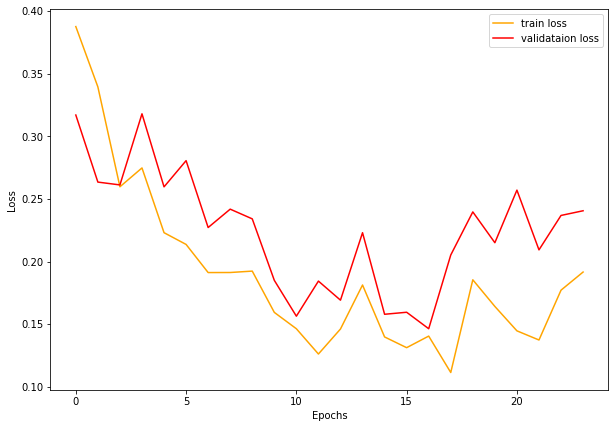

In [75]:
  plt.figure(figsize=(10, 7))
  plt.plot(train_los[1:], color='orange', label='train loss')
  plt.plot(val_los[1:], color='red', label='validataion loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig('loss.png')
  plt.show()

In [58]:
idx = 7
model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c,h,w)->(1,c,h,w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0


In [61]:
# from numpy import moveaxis
# data1 = cv2.imread('/content/102.jpg')
# data2 = cv2.cvtColor(data1, cv2.COLOR_BGR2RGB)
# data3 = np.resize(data2,(320,320,3))
# data = np.transpose(data3, (2,0,1)).astype(np.float32)

# data = torch.from_numpy(data)

# logit_mask = model(data.to(DEVICE).unsqueeze(0)) #(c,h,w)->(1,c,h,w)
# pre_mask = torch.sigmoid(logit_mask)
# pre_mask = (pre_mask > 0.5)*1.0
# x = pre_mask.detach().cpu().squeeze()
# x1=x.numpy()
# plt.imshow(data3)

In [59]:
from skimage.metrics import (adapted_rand_error,
                              variation_of_information)

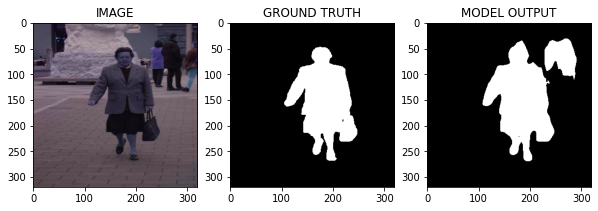

In [60]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [62]:
p=pred_mask.detach().cpu().squeeze()

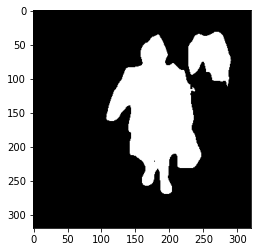

In [63]:
p1=p.numpy()
plt.imshow(p1,cmap='gray')

In [64]:
from sklearn import metrics

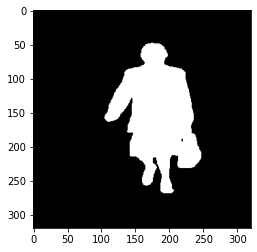

In [65]:
m1=mask.squeeze().numpy()
plt.imshow(m1,cmap='gray')


In [66]:
print("Accuracy=",metrics.accuracy_score(m1,p1))

Accuracy= 0.309375


In [67]:
from keras.metrics import MeanIoU
num_classes = 2
IOU_keras = MeanIoU(num_classes=num_classes)
IOU_keras.update_state(m1,p1)
print("Mean IoU =", IOU_keras.result().numpy())


Mean IoU = 0.8679962


In [68]:
m = m1.astype(int)
p = p1.astype(int)


#from skimage.metrics import (adapted_rand_error,
                              #variation_of_information)
error, precision, recall = adapted_rand_error(m, p)
precision,recall

(0.9745105133895007, 1.0)

In [ ]:
#THE END